In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## Preprocessing

In [ ]:
def preprocess(text):
    '''
    >>> eg_text = 'You say goodbye and I say hello.'
    >>> corpus, word2id, id2word = preprocess(eg_text)
    >>> print(corpus)
    [0 1 2 3 4 1 5 6]
    >>> print(word2id)
    {'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
    >>> print(id2word)
    {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}
    '''
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    # 'ppp' exercise
    word_to_id = {}
    id_to_word = {}

    for word in words:
      new_id = len(word_to_id)
      word_to_id[word] = new_id
      id_to_word[new_id] = word

    corpus = np.array([word_to_id[w]] for w in words)

    return corpus, word_to_id, id_to_word

In [ ]:
eg_text = 'You say goodbye and I say hello.'
corpus, word2id, id2word = preprocess(eg_text)
print(corpus)
print(word2id)
print(id2word)

<generator object preprocess.<locals>.<genexpr> at 0x7850d47098c0>
{'you': 0, 'say': 5, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


## Count-based methods

### Co-occurence matrix

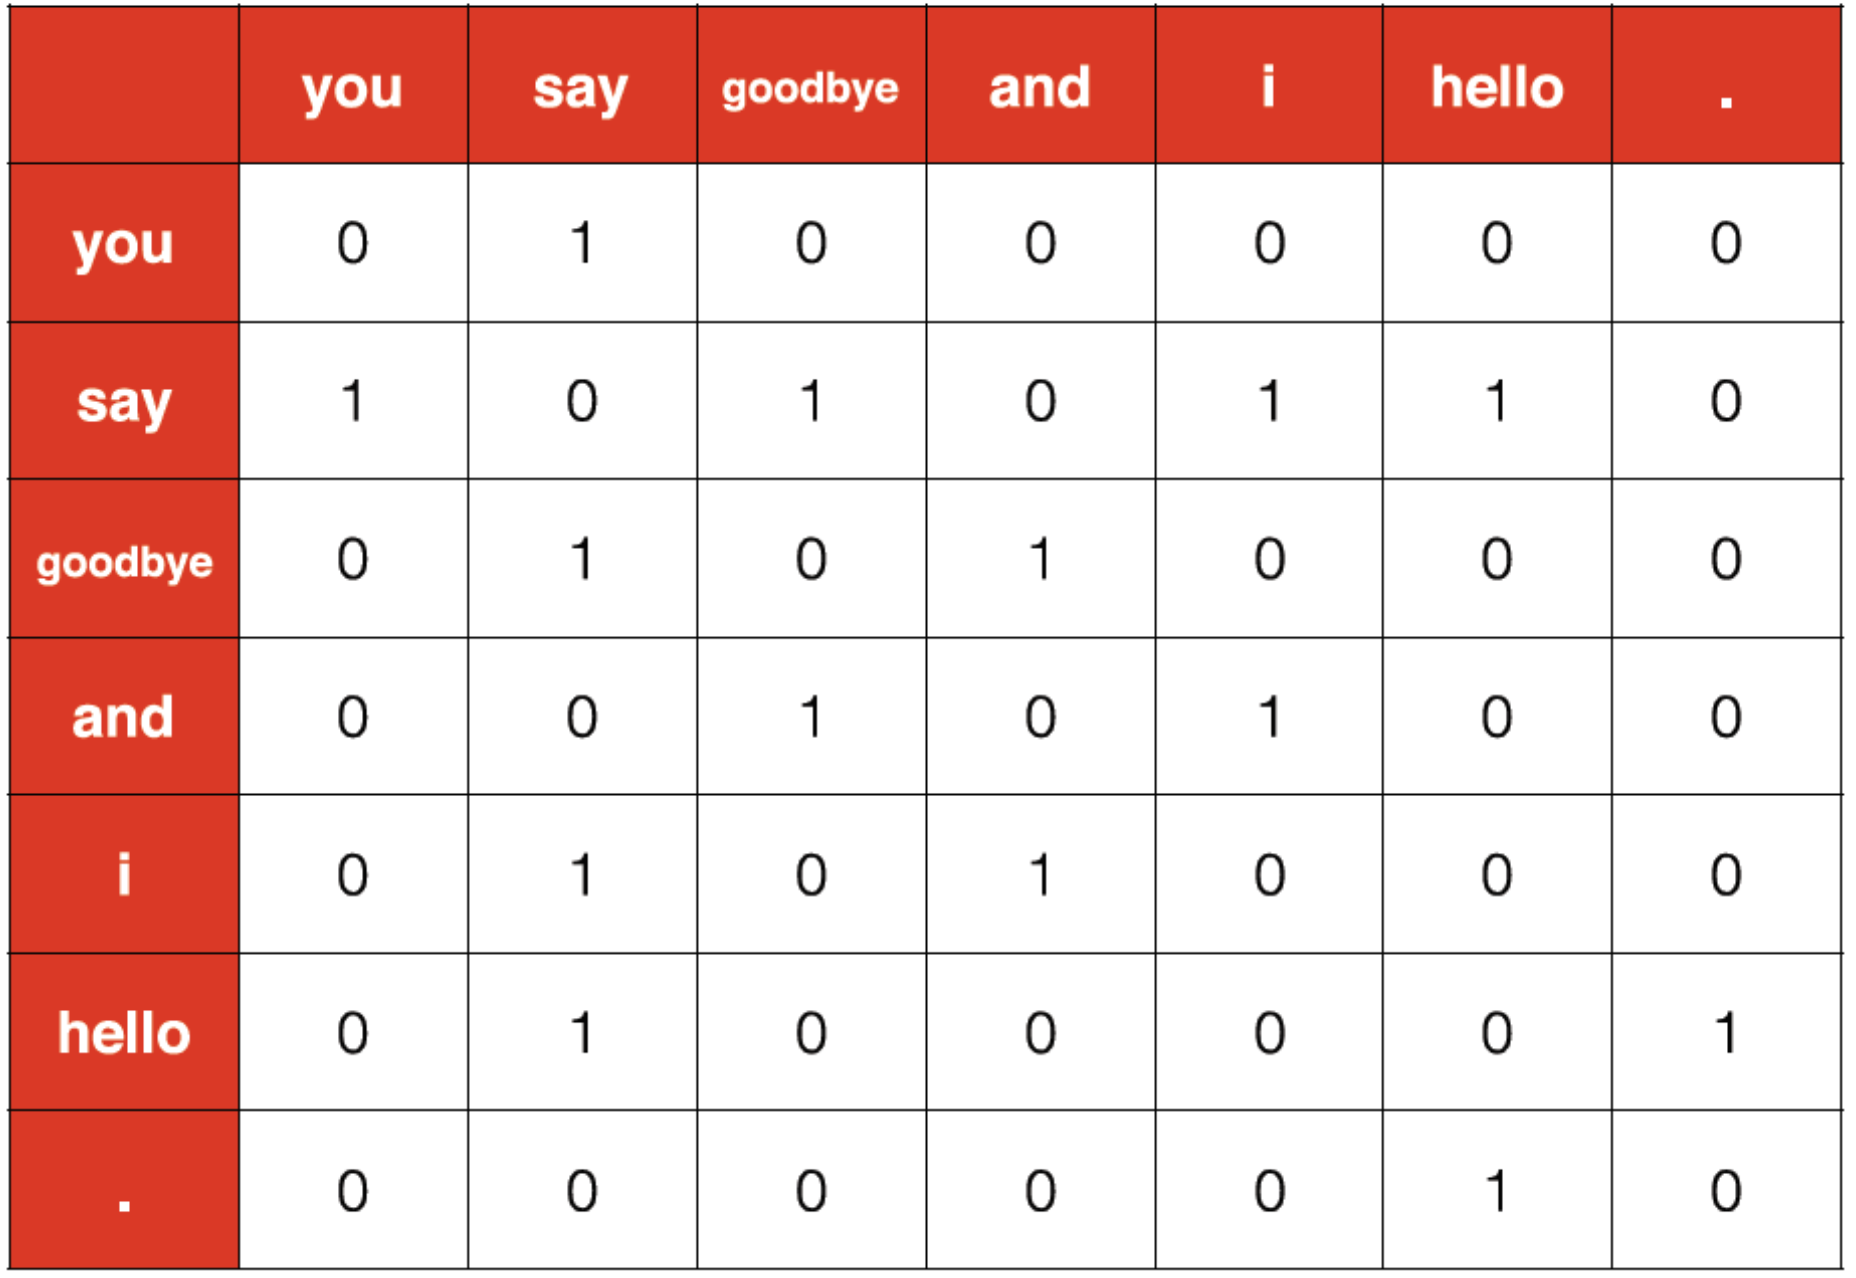

In [ ]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    '''
    :param corpus: the list of ID's
    :param vocab_size: number of vocabs
    :param window_size: window size to capture context
    :return: co-occurence matrix
    '''
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

    return co_matrix

In [ ]:
C = create_co_matrix(corpus, len(word2id))
print(C)

TypeError: ignored

### Similarities

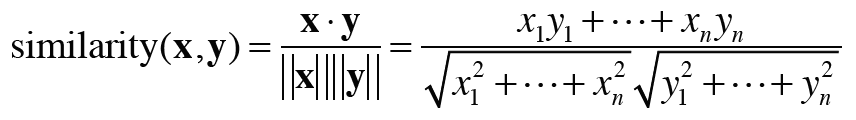

In [ ]:
def cos_similarity(x, y, eps=1e-8):
    # 'ppp' exercise
    nx = x / (np.sqrt(np.sum(x**2))+ np.eps)
    ny = y / (np.sqrt(np.sum(x**2))+ np.eps)
    return np.dot(nx, ny)

In [ ]:
c0 = C[word2id['you']]
c1 = C[word2id['i']]
print(cos_similarity(c0, c1))

NameError: ignored

In [ ]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    '''searching for most similar words
    '''
    if query not in word_to_id:
        print("Can't find %s!" % query)
        return

    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    # calculate cosine similarity
    vocab_size = len(id_to_word)

    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    # sort the words according to cosine similarity
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return

### PPMI

In [ ]:
def ppmi(C, verbose=False, eps=1e-8):
    '''PPMI: positive pointwise mutual information

    :param C: co-occurrence matrix
    :param verbose: to print-out the process
    :return:
    '''
    # 'ppp' exercise
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S =np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]

    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
          pmi = np.log2(C[i,j]) * N / (S[j]* S[i] + eps)
          M[i, j] = max(0, pmi)

          if verbose:
            cnt += 1
            if cnt % (total // 10+1) ==0:
              print('%.11%% completed '% (100 * cnt / total))

    return M


In [ ]:
W = ppmi(C)
np.set_printoptions(precision=3)

print("Co-occurrence matrix")
print(C)
print('-' * 50)
print('PPMI')
print(W)

Co-occurrence matrix
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


### Dimension reduction

In [ ]:
U, S, V = np.linalg.svd(W)

In [ ]:
print(C[0])
print(W[0])
print(U[0])
print(U[0, :2])  # dimension reduction

[0 1 0 0 0 0 0]
[0.    1.807 0.    0.    0.    0.    0.   ]
[ 3.409e-01 -1.110e-16 -1.205e-01 -4.163e-16 -9.323e-01 -1.110e-16
 -2.426e-17]
[ 3.409e-01 -1.110e-16]


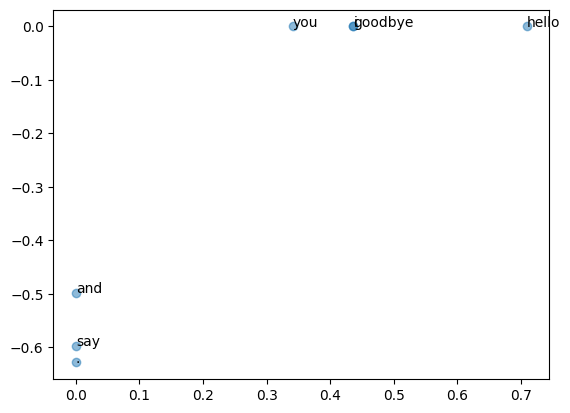

In [ ]:
for word, word_id in word2id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:, 0], U[:, 1], alpha=0.5)
plt.show()

## PTB dataset

In [ ]:
import os
import sys
import pickle
sys.path.append('..')
import urllib.request

In [ ]:
url_base = 'https://raw.githubusercontent.com/tomsercu/lstm/master/data/'
key_file = {
    'train':'ptb.train.txt',
    'test':'ptb.test.txt',
    'valid':'ptb.valid.txt'
}
save_file = {
    'train':'ptb.train.npy',
    'test':'ptb.test.npy',
    'valid':'ptb.valid.npy'
}
vocab_file = 'ptb.vocab.pkl'

dataset_dir = os.path.dirname('/content/sample_data')


def _download(file_name):
    file_path = dataset_dir + '/' + file_name
    if os.path.exists(file_path):
        return

    print('Downloading ' + file_name + ' ... ')

    try:
        urllib.request.urlretrieve(url_base + file_name, file_path)
    except urllib.error.URLError:
        import ssl
        ssl._create_default_https_context = ssl._create_unverified_context
        urllib.request.urlretrieve(url_base + file_name, file_path)

    print('Done')


def load_vocab():
    vocab_path = dataset_dir + '/' + vocab_file

    if os.path.exists(vocab_path):
        with open(vocab_path, 'rb') as f:
            word_to_id, id_to_word = pickle.load(f)
        return word_to_id, id_to_word

    word_to_id = {}
    id_to_word = {}
    data_type = 'train'
    file_name = key_file[data_type]
    file_path = dataset_dir + '/' + file_name

    _download(file_name)

    words = open(file_path).read().replace('\n', '<eos>').strip().split()

    for i, word in enumerate(words):
        if word not in word_to_id:
            tmp_id = len(word_to_id)
            word_to_id[word] = tmp_id
            id_to_word[tmp_id] = word

    with open(vocab_path, 'wb') as f:
        pickle.dump((word_to_id, id_to_word), f)

    return word_to_id, id_to_word


def load_data(data_type='train'):
    '''
        :param data_type: 'train' or 'test' or 'valid (val)'
        :return:
    '''
    if data_type == 'val': data_type = 'valid'
    save_path = dataset_dir + '/' + save_file[data_type]

    word_to_id, id_to_word = load_vocab()

    if os.path.exists(save_path):
        corpus = np.load(save_path)
        return corpus, word_to_id, id_to_word

    file_name = key_file[data_type]
    file_path = dataset_dir + '/' + file_name
    _download(file_name)

    words = open(file_path).read().replace('\n', '<eos>').strip().split()
    corpus = np.array([word_to_id[w] for w in words])

    np.save(save_path, corpus)
    return corpus, word_to_id, id_to_word

### Demo with the PTB dataset

In [ ]:
window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = load_data('train')
vocab_size = len(word_to_id)
print('co-occurrence calculation ...')
C = create_co_matrix(corpus, vocab_size, window_size)
print('PPMI calculation ...')
W = ppmi(C, verbose=True)

print('calculating SVD ...')
try:
    # truncated SVD (fast!)
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5,
                             random_state=None)
except ImportError:
    # SVD (slow)
    U, S, V = np.linalg.svd(W)

word_vecs = U[:, :wordvec_size]

queries = ['you', 'year', 'car', 'toyota']
for query in queries:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)